<a href="https://colab.research.google.com/github/cohitai/AI_notebooks/blob/main/VAE/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variational AutoEncoder = (encoder= Q(Z|X)=Recognition model, decoder=P(X|Z)=Generative model)+ Variational loss.

 Variational loss = ELBO (evidence lower bound). 



In [1]:
#ToDO: visualizations of the latent space, KL divergence explanations, Generative data. 

# Go over these: 

# https://avandekleut.github.io/vae/

# https://github.com/AntixK/PyTorch-VAE (many different types of VAEs)
# https://www.jeremyjordan.me/variational-autoencoders/
# https://gaussian37.github.io/deep-learning-chollet-8-4/
# https://medium.com/@arjun.majumdar/variational-autoencoder-cifar-10-tf2-9ed1155771e1
# https://github.com/arjun-majumdar/Autoencoders_Experiments/blob/master/Variational_AutoEncoder_CIFAR10_TF2.ipynb
# https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed
# https://colab.research.google.com/drive/1_yGmk8ahWhDs23U4mpplBFa-39fsEJoT?usp=sharing#scrollTo=xOVursP7lpR-

# More ToDo's:
# 1. plot the losses.
# 2. plot reconstruction versus original images as 2 X M subplot. 
# 2. Visualization of the latent space from https://avandekleut.github.io/vae/
# 3. evaluation data + some kind of accuracy
# 4. sum() or mean() in loss , and kl.sum() (probabely) or kl.mean() ?  (stochstic !)
# 5. Compare the loss with the pretrained VAE model(Huggingfaces). 

# Improvements
# 0. adjust the learning rate better
# 1. Exponential Learning rate ? shadow variables etc 
# 2. Perceptual Losses for Deep Image Restoration
# 3. https://towardsdatascience.com/perceptual-losses-for-image-restoration-dd3c9de4113
# 4. Compare the loss with the pretrained VAE model(Huggingfaces). 


# Theory: main paper on VAE: (Auto-Encoding Variational Bayes) at https://arxiv.org/pdf/1312.6114.pdf

# Unet variations
# Unet: https://amaarora.github.io/2020/09/13/unet.html
# Unet paper: U-Net: Convolutional Networks for Biomedical Image Segmentation (https://arxiv.org/pdf/1505.04597.pdf)

# Diffusers on local M1 ANE (transfer to Colab). 

In [2]:
import torch 
import torchvision
from torch import nn
import torch.nn.functional as F
import numpy as np
import os
import math

from google.colab import drive
drive.mount('/content/gdrive')

print("Working directory:", os.getcwd())
device="cuda"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Working directory: /content


In [146]:
!nvidia-smi

Fri Nov 18 22:58:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    30W /  70W |  10034MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Model Blocks:
 - DownEncoderBlock2D

 - UpDecoderBlock2D

 - ResnetBlock

 - Downsample2D

 - Upsample2D

 - AttentionBlockNew

 - UNetMidBlock2D

 - Encoder

 - Decoder


In [4]:
class DownEncoderBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        dropout: float = 0.0, 
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        output_scale_factor=1.0,
        add_downsample=True,
        downsample_padding=1,
    ):
        super().__init__()
        resnets = []

        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnets.append(
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    temb_channels=None,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        self.resnets = nn.ModuleList(resnets)

        if add_downsample:
            self.downsamplers = nn.ModuleList(
                [
                    Downsample2D(
                        in_channels, use_conv=True, out_channels=out_channels, padding=downsample_padding, name="op"
                    )
                ]
            )
        else:
            self.downsamplers = None

    def forward(self, hidden_states):
        for resnet in self.resnets:
            hidden_states = resnet(hidden_states, temb=None)

        if self.downsamplers is not None:
            for downsampler in self.downsamplers:
                hidden_states = downsampler(hidden_states)

        return hidden_states

class UpDecoderBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        output_scale_factor=1.0,
        add_upsample=True,
    ):
        super().__init__()
        resnets = []

        for i in range(num_layers):
            input_channels = in_channels if i == 0 else out_channels

            resnets.append(
                ResnetBlock(
                    in_channels=input_channels,
                    out_channels=out_channels,
                    temb_channels=None,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        self.resnets = nn.ModuleList(resnets)

        if add_upsample:
            self.upsamplers = nn.ModuleList([Upsample2D(out_channels, use_conv=True, out_channels=out_channels)])
        else:
            self.upsamplers = None

    def forward(self, hidden_states):
        for resnet in self.resnets:
            hidden_states = resnet(hidden_states, temb=None)

        if self.upsamplers is not None:
            for upsampler in self.upsamplers:
                hidden_states = upsampler(hidden_states)

        return hidden_states

  
    
class ResnetBlock(nn.Module):
    def __init__(
        self,
        *,
        in_channels,
        out_channels=None,
        conv_shortcut=False,
        dropout=0.0,
        temb_channels=512,
        groups=32,
        groups_out=None,
        pre_norm=True,
        eps=1e-6,
        non_linearity="swish",
        time_embedding_norm="default",
        kernel=None,
        output_scale_factor=1.0,
        use_nin_shortcut=None,
        up=False,
        down=False,
    ):
        super().__init__()
        self.pre_norm = pre_norm
        self.pre_norm = True
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        self.use_conv_shortcut = conv_shortcut
        self.time_embedding_norm = time_embedding_norm
        self.up = up
        self.down = down
        self.output_scale_factor = output_scale_factor

        if groups_out is None:
            groups_out = groups

        self.norm1 = torch.nn.GroupNorm(num_groups=groups, num_channels=in_channels, eps=eps, affine=True)

        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

        if temb_channels is not None:
            self.time_emb_proj = torch.nn.Linear(temb_channels, out_channels)
        else:
            self.time_emb_proj = None

        self.norm2 = torch.nn.GroupNorm(num_groups=groups_out, num_channels=out_channels, eps=eps, affine=True)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

        if non_linearity == "swish":
            self.nonlinearity = lambda x: F.silu(x)
        elif non_linearity == "mish":
            self.nonlinearity = Mish()
        elif non_linearity == "silu":
            self.nonlinearity = nn.SiLU()

        self.upsample = self.downsample = None
        if self.up:
            if kernel == "fir":
                fir_kernel = (1, 3, 3, 1)
                self.upsample = lambda x: upsample_2d(x, k=fir_kernel)
            elif kernel == "sde_vp":
                self.upsample = partial(F.interpolate, scale_factor=2.0, mode="nearest")
            else:
                self.upsample = Upsample2D(in_channels, use_conv=False)
        
        elif self.down:
            if kernel == "fir":
                fir_kernel = (1, 3, 3, 1)
                self.downsample = lambda x: downsample_2d(x, k=fir_kernel)
            elif kernel == "sde_vp":
                self.downsample = partial(F.avg_pool2d, kernel_size=2, stride=2)
            else:
                self.downsample = Downsample2D(in_channels, use_conv=False, padding=1, name="op")

        self.use_nin_shortcut = self.in_channels != self.out_channels if use_nin_shortcut is None else use_nin_shortcut

        self.conv_shortcut = None
    
        if self.use_nin_shortcut:
            self.conv_shortcut = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, temb, hey=False):
        h = x

        # print("LOG resnet_input",h.size())

        # make sure hidden states is in float32
        # when running in half-precision
        h = self.norm1(h.float()).type(h.dtype)
        h = self.nonlinearity(h)

        # if self.upsample is not None:
        #     x = self.upsample(x)
        #     h = self.upsample(h)
        # elif self.downsample is not None:
        #     x = self.downsample(x)
        #     h = self.downsample(h)

        h = self.conv1(h)

        # print("LOG temb:",temb is None)

        # if temb is not None:
        #     temb = self.time_emb_proj(self.nonlinearity(temb))[:, :, None, None]
        #     h = h + temb

        # make sure hidden states is in float32
        # when running in half-precision
        h = self.norm2(h.float()).type(h.dtype)
        h = self.nonlinearity(h)

        h = self.dropout(h)
        h = self.conv2(h)

        if self.conv_shortcut is not None:
            x = self.conv_shortcut(x)

        out = (x + h) / self.output_scale_factor

        return out

    def set_weight(self, resnet):
        self.norm1.weight.data = resnet.norm1.weight.data
        self.norm1.bias.data = resnet.norm1.bias.data

        self.conv1.weight.data = resnet.conv1.weight.data
        self.conv1.bias.data = resnet.conv1.bias.data

        if self.time_emb_proj is not None:
            self.time_emb_proj.weight.data = resnet.temb_proj.weight.data
            self.time_emb_proj.bias.data = resnet.temb_proj.bias.data

        self.norm2.weight.data = resnet.norm2.weight.data
        self.norm2.bias.data = resnet.norm2.bias.data

        self.conv2.weight.data = resnet.conv2.weight.data
        self.conv2.bias.data = resnet.conv2.bias.data

        if self.use_nin_shortcut:
            self.conv_shortcut.weight.data = resnet.nin_shortcut.weight.data
            self.conv_shortcut.bias.data = resnet.nin_shortcut.bias.data
            
            
class Downsample2D(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs. :param use_conv: a bool determining if a convolution is
    applied. :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 downsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv=False, out_channels=None, padding=1, name="conv"):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.padding = padding
        stride = 2
        self.name = name

        if use_conv:
            conv = nn.Conv2d(self.channels, self.out_channels, 3, stride=stride, padding=padding)
        else:
            assert self.channels == self.out_channels
            conv = nn.AvgPool2d(kernel_size=stride, stride=stride)

        # TODO(Suraj, Patrick) - clean up after weight dicts are correctly renamed
        if name == "conv":
            self.Conv2d_0 = conv
            self.conv = conv
        elif name == "Conv2d_0":
            self.conv = conv
        else:
            self.conv = conv

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.use_conv and self.padding == 0:
            pad = (0, 1, 0, 1)
            x = F.pad(x, pad, mode="constant", value=0)

        assert x.shape[1] == self.channels
        x = self.conv(x)

        return x

class Upsample2D(nn.Module):

    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs. :param use_conv: a bool determining if a convolution is
    applied. :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 upsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv=False, use_conv_transpose=False, out_channels=None, name="conv"):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_conv_transpose = use_conv_transpose
        self.name = name

        conv = None
        if use_conv_transpose:
            conv = nn.ConvTranspose2d(channels, self.out_channels, 4, 2, 1)
        elif use_conv:
            conv = nn.Conv2d(self.channels, self.out_channels, 3, padding=1)

        # TODO(Suraj, Patrick) - clean up after weight dicts are correctly renamed
        if name == "conv":
            self.conv = conv
        else:
            self.Conv2d_0 = conv

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.use_conv_transpose:
            return self.conv(x)

        x = F.interpolate(x, scale_factor=2.0, mode="nearest")

        # TODO(Suraj, Patrick) - clean up after weight dicts are correctly renamed
        if self.use_conv:
            if self.name == "conv":
                x = self.conv(x)
            else:
                x = self.Conv2d_0(x)

        return x


class AttentionBlockNew(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other. Originally ported from here, but adapted
    to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    Uses three q, k, v linear layers to compute attention
    """

    def __init__(
        self,
        channels,
        num_head_channels=None,
        num_groups=32,
        rescale_output_factor=1.0,
        eps=1e-5,
    ):
        super().__init__()
        self.channels = channels

        self.num_heads = channels // num_head_channels if num_head_channels is not None else 1
        self.num_head_size = num_head_channels
        self.group_norm = nn.GroupNorm(num_channels=channels, num_groups=num_groups, eps=eps, affine=True)

        # define q,k,v as linear layers
        self.query = nn.Linear(channels, channels)
        self.key = nn.Linear(channels, channels)
        self.value = nn.Linear(channels, channels)

        self.rescale_output_factor = rescale_output_factor
        self.proj_attn = nn.Linear(channels, channels, 1)

    def transpose_for_scores(self, projection: torch.Tensor) -> torch.Tensor:
        new_projection_shape = projection.size()[:-1] + (self.num_heads, -1)
        # move heads to 2nd position (B, T, H * D) -> (B, T, H, D) -> (B, H, T, D)
        new_projection = projection.view(new_projection_shape).permute(0, 2, 1, 3)
        return new_projection

    def forward(self, hidden_states):
        residual = hidden_states
        batch, channel, height, width = hidden_states.shape

        # norm
        hidden_states = self.group_norm(hidden_states)

        hidden_states = hidden_states.view(batch, channel, height * width).transpose(1, 2)

        # proj to q, k, v
        query_proj = self.query(hidden_states)
        key_proj = self.key(hidden_states)
        value_proj = self.value(hidden_states)

        # transpose
        query_states = self.transpose_for_scores(query_proj)
        key_states = self.transpose_for_scores(key_proj)
        value_states = self.transpose_for_scores(value_proj)

        # get scores
        scale = 1 / math.sqrt(math.sqrt(self.channels / self.num_heads))
        attention_scores = torch.matmul(query_states * scale, key_states.transpose(-1, -2) * scale)
        attention_probs = torch.softmax(attention_scores.float(), dim=-1).type(attention_scores.dtype)

        # compute attention output
        context_states = torch.matmul(attention_probs, value_states)

        context_states = context_states.permute(0, 2, 1, 3).contiguous()
        new_context_states_shape = context_states.size()[:-2] + (self.channels,)
        context_states = context_states.view(new_context_states_shape)

        # compute next hidden_states
        hidden_states = self.proj_attn(context_states)
        hidden_states = hidden_states.transpose(-1, -2).reshape(batch, channel, height, width)

        # res connect and rescale
        hidden_states = (hidden_states + residual) / self.rescale_output_factor
        return hidden_states

    def set_weight(self, attn_layer):
        self.group_norm.weight.data = attn_layer.norm.weight.data
        self.group_norm.bias.data = attn_layer.norm.bias.data

        if hasattr(attn_layer, "q"):
            self.query.weight.data = attn_layer.q.weight.data[:, :, 0, 0]
            self.key.weight.data = attn_layer.k.weight.data[:, :, 0, 0]
            self.value.weight.data = attn_layer.v.weight.data[:, :, 0, 0]

            self.query.bias.data = attn_layer.q.bias.data
            self.key.bias.data = attn_layer.k.bias.data
            self.value.bias.data = attn_layer.v.bias.data

            self.proj_attn.weight.data = attn_layer.proj_out.weight.data[:, :, 0, 0]
            self.proj_attn.bias.data = attn_layer.proj_out.bias.data
        elif hasattr(attn_layer, "NIN_0"):
            self.query.weight.data = attn_layer.NIN_0.W.data.T
            self.key.weight.data = attn_layer.NIN_1.W.data.T
            self.value.weight.data = attn_layer.NIN_2.W.data.T

            self.query.bias.data = attn_layer.NIN_0.b.data
            self.key.bias.data = attn_layer.NIN_1.b.data
            self.value.bias.data = attn_layer.NIN_2.b.data

            self.proj_attn.weight.data = attn_layer.NIN_3.W.data.T
            self.proj_attn.bias.data = attn_layer.NIN_3.b.data

            self.group_norm.weight.data = attn_layer.GroupNorm_0.weight.data
            self.group_norm.bias.data = attn_layer.GroupNorm_0.bias.data
        else:
            qkv_weight = attn_layer.qkv.weight.data.reshape(
                self.num_heads, 3 * self.channels // self.num_heads, self.channels
            )
            qkv_bias = attn_layer.qkv.bias.data.reshape(self.num_heads, 3 * self.channels // self.num_heads)

            q_w, k_w, v_w = qkv_weight.split(self.channels // self.num_heads, dim=1)
            q_b, k_b, v_b = qkv_bias.split(self.channels // self.num_heads, dim=1)

            self.query.weight.data = q_w.reshape(-1, self.channels)
            self.key.weight.data = k_w.reshape(-1, self.channels)
            self.value.weight.data = v_w.reshape(-1, self.channels)

            self.query.bias.data = q_b.reshape(-1)
            self.key.bias.data = k_b.reshape(-1)
            self.value.bias.data = v_b.reshape(-1)

            self.proj_attn.weight.data = attn_layer.proj.weight.data[:, :, 0]
            self.proj_attn.bias.data = attn_layer.proj.bias.data

class UNetMidBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        temb_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        attn_num_head_channels=1,
        attention_type="default",
        output_scale_factor=1.0,
        **kwargs,
    ):
        super().__init__()

        self.attention_type = attention_type
        resnet_groups = resnet_groups if resnet_groups is not None else min(in_channels // 4, 32)

        # there is always at least one resnet
        resnets = [
            ResnetBlock(
                in_channels=in_channels,
                out_channels=in_channels,
                temb_channels=temb_channels,
                eps=resnet_eps,
                groups=resnet_groups,
                dropout=dropout,
                time_embedding_norm=resnet_time_scale_shift,
                non_linearity=resnet_act_fn,
                output_scale_factor=output_scale_factor,
                pre_norm=resnet_pre_norm,
            )
        ]
        attentions = []

        for _ in range(num_layers):
            attentions.append(
                AttentionBlockNew(
                    in_channels,
                    num_head_channels=attn_num_head_channels,
                    rescale_output_factor=output_scale_factor,
                    eps=resnet_eps,
                    num_groups=resnet_groups,
                )
            )
            resnets.append(
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        self.attentions = nn.ModuleList(attentions)
        self.resnets = nn.ModuleList(resnets)

    def forward(self, hidden_states, temb=None, encoder_states=None):
        hidden_states = self.resnets[0](hidden_states, temb)
        for attn, resnet in zip(self.attentions, self.resnets[1:]):
            if self.attention_type == "default":
                hidden_states = attn(hidden_states)
            else:
                hidden_states = attn(hidden_states, encoder_states)
            hidden_states = resnet(hidden_states, temb)

        return hidden_states


class Encoder(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=4,
        down_block_types=("DownEncoderBlock2D",),
        block_out_channels=(64,),
        layers_per_block=1,
        act_fn="silu",
        double_z=True,
    ):
        super().__init__()
        self.layers_per_block = layers_per_block
        self.conv_in = torch.nn.Conv2d(in_channels, block_out_channels[0], kernel_size=3, stride=1, padding=1)
        self.mid_block = None
        self.down_blocks = nn.ModuleList([])

        # down
        output_channel = block_out_channels[0]
        for i, _ in enumerate(down_block_types):
            input_channel = output_channel
            output_channel = block_out_channels[i]
            is_final_block = i == len(block_out_channels) - 1

            down_block = DownEncoderBlock2D(
                num_layers=self.layers_per_block,
                in_channels=input_channel,
                out_channels=output_channel,
                add_downsample=not is_final_block,
                resnet_eps=1e-6,
                resnet_act_fn=act_fn,
                downsample_padding=0,)

            self.down_blocks.append(down_block)

        # mid
        self.mid_block = UNetMidBlock2D(
            in_channels=block_out_channels[-1],
            resnet_eps=1e-6,
            resnet_act_fn=act_fn,
            output_scale_factor=1,
            resnet_time_scale_shift="default",
            attn_num_head_channels=None,
            resnet_groups=32,
            temb_channels=None,
        )

        # out
        num_groups_out = 32
        self.conv_norm_out = nn.GroupNorm(num_channels=block_out_channels[-1], num_groups=num_groups_out, eps=1e-6)
        self.conv_act = nn.SiLU()

        conv_out_channels = 2 * out_channels if double_z else out_channels
        self.conv_out = nn.Conv2d(block_out_channels[-1], conv_out_channels, 3, padding=1)

    def forward(self, x):
        
        sample = x
        sample = self.conv_in(sample)
        
        # down
        for down_block in self.down_blocks:
            sample = down_block(sample)

        # middle
        sample = self.mid_block(sample)

        # post-process
        sample = self.conv_norm_out(sample)
        sample = self.conv_act(sample)
        sample = self.conv_out(sample)

        return sample


class Decoder(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        up_block_types=("UpDecoderBlock2D",),
        block_out_channels=(64,),
        layers_per_block=2,
        act_fn="silu",
    ):
        super().__init__()
        self.layers_per_block = layers_per_block

        self.conv_in = nn.Conv2d(in_channels, block_out_channels[-1], kernel_size=3, stride=1, padding=1)

        self.mid_block = None
        self.up_blocks = nn.ModuleList([])

        # mid
        self.mid_block = UNetMidBlock2D(
            in_channels=block_out_channels[-1],
            resnet_eps=1e-6,
            resnet_act_fn=act_fn,
            output_scale_factor=1,
            resnet_time_scale_shift="default",
            attn_num_head_channels=None,
            resnet_groups=32,
            temb_channels=None,
        )

        # up
        reversed_block_out_channels = list(reversed(block_out_channels))
        output_channel = reversed_block_out_channels[0]
        for i, up_block_type in enumerate(up_block_types):
            prev_output_channel = output_channel
            output_channel = reversed_block_out_channels[i]

            is_final_block = i == len(block_out_channels) - 1

            up_block = UpDecoderBlock2D(
            num_layers=self.layers_per_block + 1,
            in_channels=prev_output_channel,
            out_channels=output_channel,
            add_upsample=not is_final_block,
            resnet_eps=1e-6,
            resnet_act_fn=act_fn,
        )

            self.up_blocks.append(up_block)
            prev_output_channel = output_channel

        # out
        num_groups_out = 32
        self.conv_norm_out = nn.GroupNorm(num_channels=block_out_channels[0], num_groups=num_groups_out, eps=1e-6)
        self.conv_act = nn.SiLU()
        self.conv_out = nn.Conv2d(block_out_channels[0], out_channels, 3, padding=1)

    def forward(self, z):
        sample = z
        sample = self.conv_in(sample)

        # middle
        sample = self.mid_block(sample)

        # up
        for up_block in self.up_blocks:
            sample = up_block(sample)

        # post-process
        sample = self.conv_norm_out(sample)
        sample = self.conv_act(sample)
        sample = self.conv_out(sample)

        return sample

In [5]:
class DiagonalGaussianDistribution(object):
    def __init__(self, parameters, deterministic=False):
        self.parameters = parameters
        self.mean, self.logvar = torch.chunk(parameters, 2, dim=1)
        self.logvar = torch.clamp(self.logvar, -30.0, 20.0)
        self.deterministic = deterministic
        self.std = torch.exp(0.5 * self.logvar)
        self.var = torch.exp(self.logvar)
        if self.deterministic:
            self.var = self.std = torch.zeros_like(self.mean).to(device=self.parameters.device)

    def sample(self):
        x = self.mean + self.std * torch.randn(self.mean.shape).to(device=self.parameters.device)
        return x

    def kl(self, other=None):
        if self.deterministic:
            return torch.Tensor([0.0])
        else:
            if other is None:
                return 0.5 * torch.sum(torch.pow(self.mean, 2) + self.var - 1.0 - self.logvar, dim=[1, 2, 3])
            else:
                return 0.5 * torch.sum(
                    torch.pow(self.mean - other.mean, 2) / other.var
                    + self.var / other.var
                    - 1.0
                    - self.logvar
                    + other.logvar,
                    dim=[1, 2, 3],
                )

    def nll(self, sample, dims=[1, 2, 3]):
        if self.deterministic:
            return torch.Tensor([0.0])
        logtwopi = np.log(2.0 * np.pi)
        return 0.5 * torch.sum(logtwopi + self.logvar + torch.pow(sample - self.mean, 2) / self.var, dim=dims)

    def mode(self):
        return self.mean



encoder = Encoder(in_channels=3,
        out_channels=4,
        down_block_types=("DownEncoderBlock2D",),
        block_out_channels=(64,),
        layers_per_block=1,
        act_fn="silu",
        double_z=True)


decoder = Decoder(in_channels=4,
            out_channels=3,
            up_block_types=("UpDecoderBlock2D",),
            block_out_channels=(64,),
            layers_per_block=1,
            act_fn="silu")





    ##########################
    ##########################
    ##########################
#### AutoEncoder wrap- up class ####
    ##########################
    ##########################
    ##########################

class AutoencoderKL(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        down_block_types=("DownEncoderBlock2D","DownEncoderBlock2D","DownEncoderBlock2D","DownEncoderBlock2D",),
        up_block_types=("UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D",),
        block_out_channels=(128, 256, 512, 512,),
        layers_per_block=2,
        act_fn="silu",
        latent_channels=4,
        sample_size=512,
    ):
        super().__init__()

        # pass init params to Encoder
        self.encoder = Encoder(
            in_channels=in_channels,
            out_channels=latent_channels,
            down_block_types=down_block_types,
            block_out_channels=block_out_channels,
            layers_per_block=layers_per_block,
            act_fn=act_fn,
            double_z=True,
        )

        # pass init params to Decoder
        self.decoder = Decoder(
            in_channels=latent_channels,
            out_channels=out_channels,
            up_block_types=up_block_types,
            block_out_channels=block_out_channels,
            layers_per_block=layers_per_block,
            act_fn=act_fn,
        )

        self.quant_conv = torch.nn.Conv2d(2 * latent_channels, 2 * latent_channels, 1)
        self.post_quant_conv = torch.nn.Conv2d(latent_channels, latent_channels, 1) 
        self.kl = 0

    def encode(self, x):
        h = self.encoder(x)
        moments = self.quant_conv(h)
        posterior = DiagonalGaussianDistribution(moments)
        return posterior

    def decode(self, z):
        z = self.post_quant_conv(z)
        dec = self.decoder(z)
        return dec

    def forward(self, sample, sample_posterior=False):
        x = sample
        posterior = self.encode(x)
        if sample_posterior:
            z = posterior.sample()
        else:
            z = posterior.mode()
        dec = self.decode(z)
        self.kl=posterior.kl()
        # print("LOG KL:",self.kl.sum())
        return dec


# **Training function**

In [145]:
##### train
from tqdm.auto import tqdm
PATH = './vae_net.pth' # default path
losses=[]

def train(autoencoder, data, epochs=20,exp=None,lr=0.001,schedualer_step=1000):
    
    def adjust(sample):
        # sample=np.expand_dims(np.asarray(sample), axis=0)
        sample=sample.numpy()/ 1.0
        # sample=sample.astype('float32')
        sample = torch.from_numpy(sample).float() # Batch - RGB channel - WxH 
        sample = 2 * (sample - 0.5) # values between (-1, 1)
        return sample
      
    def variational_loss(x,x_hat):
        return F.mse_loss(x,x_hat) + torch.mean(autoencoder.kl,dim=0)

    if exp:
        model_file='./{}_net.pth'.format(exp)
    else:
        model_file=PATH
    
    global opt
    opt = torch.optim.Adam(autoencoder.parameters(),lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9,verbose=True)
    epoch = 0

    if os.path.exists(model_file):
      checkpoint = torch.load(model_file)
      autoencoder.load_state_dict(checkpoint['model_state_dict'])
      opt.load_state_dict(checkpoint['optimizer_state_dict'])
      scheduler.load_state_dict(checkpoint['scheduler'])
      epoch = checkpoint['epoch']
      loss = checkpoint['loss']

    for epoch in range(epoch, epochs):
        # print("Log epoch:",epoch)

       with tqdm(data, unit="batch",total=len(data)) as tepoch:
        for i, x in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            x=adjust(x[0]) # Values between -1..1 
            x = torch.Tensor(x).to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x,sample_posterior=True)
            reconstruction_loss=((x - x_hat)**2).sum()
            kl_loss=autoencoder.kl.sum()
            # print("LOG reconstruction loss:", reconstruction_loss)
            # print("LOG KL:",kl_loss)
            # loss = reconstruction_loss + kl_loss
            loss = variational_loss(x,x_hat)
            loss.backward()
            opt.step()
            loss=loss.item()
            losses.append(loss)
            tepoch.set_postfix(loss=loss)

            # print(loss)

            if not i % schedualer_step and i != 0: 
                torch.save({
                'epoch': epoch,
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': loss,
                'scheduler':scheduler.state_dict()}, model_file)
                
                print("model saved!")
                scheduler.step()
        
        torch.save({
                'epoch': epoch,
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': loss,
                'scheduler':scheduler.state_dict()}, model_file)
        print("model saved!")
   
    return autoencoder

**DataLoader Cifar10** 

In [9]:
#ToDo: https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb
# normalize dataset.

def load_data(BS=32,path = "./cifar-10-batches-py",num_workers=4):
    train = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(path,
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=BS,
        shuffle=True,
        num_workers=num_workers)
    
    test = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(path,
               transform=torchvision.transforms.ToTensor(),
               download=True,train=False),
        batch_size=BS,
        shuffle=True,
        num_workers=num_workers)
        
    print(train.dataset)
    print(test.dataset)
    print("train data size:",next(iter(train))[0].size())

    return train,test


**Train/Test Split**


Training Variational AutoEncoder on Cifar10 data.

In [42]:
train_data,test_data=load_data(BS=32,num_workers=4)
vae=AutoencoderKL().to(device)
vae = train(vae, train_data,epochs=10,exp="test8",lr=1e-3,schedualer_step=300)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar-10-batches-py
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./cifar-10-batches-py
    Split: Test
    StandardTransform
Transform: ToTensor()
train data size: torch.Size([32, 3, 32, 32])
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/1563 [00:00<?, ?batch/s]

model saved!
Adjusting learning rate of group 0 to 9.0000e-04.
model saved!
Adjusting learning rate of group 0 to 8.1000e-04.
model saved!
Adjusting learning rate of group 0 to 7.2900e-04.
model saved!
Adjusting learning rate of group 0 to 6.5610e-04.
model saved!
Adjusting learning rate of group 0 to 5.9049e-04.
model saved!
Adjusting learning rate of group 0 to 5.3144e-04.
model saved!
Adjusting learning rate of group 0 to 4.7830e-04.
model saved!
Adjusting learning rate of group 0 to 4.3047e-04.
model saved!
Adjusting learning rate of group 0 to 3.8742e-04.
model saved!
Adjusting learning rate of group 0 to 3.4868e-04.


KeyboardInterrupt: ignored

#Check the results

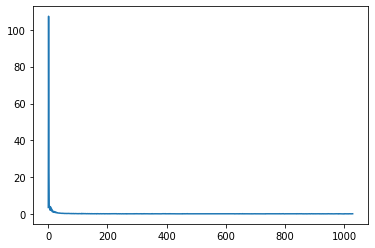

In [43]:
from matplotlib.pyplot import plot

plot(losses)

In [44]:
from matplotlib.pyplot import imshow
%matplotlib inline
def decode_img(img):
    from PIL import Image
    img = (img / 2 + 0.5).clamp(0, 1)
    img = img.detach().cpu().permute(1, 2, 0).numpy()
    img = (img * 255).round().astype('uint8')
    pil_image = Image.fromarray(img)
    return pil_image

def adjust(sample):
        # sample=np.expand_dims(np.asarray(sample), axis=0)
        sample=sample.numpy()/ 1.0
        # sample=sample.astype('float32')
        sample = torch.from_numpy(sample).float() # Batch - RGB channel - WxH 
        sample = 2 * (sample - 0.5) # values between (-1, 1)
        return sample


In [81]:
!ls -la

total 3300700
drwxr-xr-x 1 root root       4096 Nov 18 22:35 .
drwxr-xr-x 1 root root       4096 Nov 18 16:59 ..
drwxr-xr-x 3 root root       4096 Nov 18 17:25 cifar-10-batches-py
drwxr-xr-x 4 root root       4096 Nov 16 14:34 .config
drwx------ 5 root root       4096 Nov 18 17:05 gdrive
drwxr-xr-x 1 root root       4096 Nov 16 14:35 sample_data
-rw-r--r-- 1 root root  367413440 Nov 18 17:30 test4_net.pth
-rw-r--r-- 1 root root 1004151233 Nov 18 20:24 test5_net.pth
-rw-r--r-- 1 root root 1004151233 Nov 18 22:13 test6_net.pth
-rw-r--r-- 1 root root 1004151233 Nov 18 22:41 test7_net.pth


In [110]:
!ls gdrive/MyDrive/*.pth

gdrive/MyDrive/None_net.pth  gdrive/MyDrive/test1_net.pth


In [140]:
exp="test5"
checkpoint = torch.load(f"./{exp}_net.pth")
vae.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

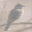

In [143]:
batch_imgs = next(iter(test_data))[0]
img=batch_imgs[0]
decode_img(img)

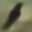

In [144]:
output=vae(adjust(torch.Tensor(img)[None, :]).to(device))[0]
decode_img(output)

In [ ]:
!ls

cifar-10-batches-py  gdrive  sample_data  test2_net.pth  test3_net.pth
